# SmallGrayReg: Cats vs Dogs: Custom Model

Using the Cat vs Dog dataset, we will read the data files into memory as-is. The preprocessing of this image will be to resized to smaller dimensions, convert to grayscale, and a min-max scaling will be performed on the pixel values of the image (divide by 255, which is the maximum possible value a pixel can hold). We will feed the processed dataset into a customly defined Convolutional Neural Network model, which will be trained for 25 epochs. This is intended to show the standard preprocessing techniques used for image processing.

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import kerastuner        as kt
import cv2
import os
from tensorflow    import keras
from sklearn.utils import shuffle
from timeit        import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Dog_vs_Cat/'
data_classes    = os.listdir( data_root_dir + 'training_set/' )
training_subdir = 'training_set/'
testing_subdir  = 'test_set/'
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Dog_vs_Cat/training_set/cats/cat.1.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.10.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.100.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1000.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1001.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1002.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1003.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1004.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1005.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1006.jpg']

Testing Set: 
['Dataset/Dog_vs_Cat/test_set/cats/cat.4001.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4002.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4003.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4004.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4005.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4006.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4007.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4008.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4009.jpg', 'Dat

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. Analyzing the dataset showed that the average training image shape was `(360,400)`. In order to maintain the integrity of the experiment, all images were manually reshaped to be a square which is a factor of of this larger dimension `(400,400) --> (80,80)`. We also convert the read images into float32 for post-regularization data

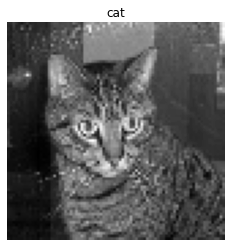

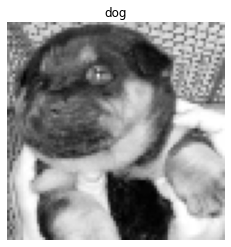

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (80,80): a 80x80 grayscale image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (gray=1)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(80,80) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0], desired_shape[1] ) , dtype=np.float32 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i][ file_list[i].rfind('/')+1:file_list[i].index( '.' ) ]  # either "dog" or "cat"
        X[i] = cv2.resize( 
                    cv2.imread( file_list[i] , cv2.IMREAD_GRAYSCALE ), 
                    ( desired_shape[0] , desired_shape[1] ) 
                ) / 255
        
    # === Return Results === #
    return X.reshape( X.shape[0] , X.shape[1], X.shape[2], 1 ) , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx] , cmap='gray' )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

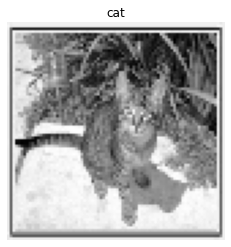

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )

# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having two class categories, we will translate the two possible classes to either a zero or a one to let the numerical output of the model specify the predicted class of the data. 

    Cat --> 0
    Dog --> 1

This translation is performed against both the training and validation labels. 

In [5]:
# === Key to Translate in Either Direction
label_keys = {
    'cat' : 0,
    'dog' : 1,
    0     : 'cat',
    1     : 'dog'
}

# === Update Training y === #
y_train[y_train=='cat'] = 0
y_train[y_train=='dog'] = 1
y_train = y_train.astype( X_train.dtype )

# === Update Testing y === #
y_test[y_test=='cat'] = 0
y_test[y_test=='dog'] = 1
y_test = y_test.astype( X_test.dtype )

# === Prove Success === #
y_train

array([0., 0., 1., ..., 1., 0., 1.], dtype=float32)

## Create Model with Tuning Options

We will be using a convolutional neural network, whose layers are specified below. The model contains three convolution layers, each with the same size kernel, but twice as many filters as the previous. After each convolution layer is a 2x2 pooling layer in order to keep the number of parameters from exploding to a number too large for the current GPU to handle (the RTX 2070 has 8GB of memory available). After the final convolution and pooling, we flatten the results, and use two fully connected layers for the classification -- the first having 64 nodes, and the second having a single node. All layers which utilize an activation function use the ReLU function, except for the output layer, which uses sigmoid. 

In terms of tuning, we will test ten different learning rates between `1e-5` and `1e-4` in order to determine which one best converges the model in terms of accuracy. 

In [6]:
def model_builder( hp ):
    model_layers = [
        keras.Input( shape=X_train[0].shape , name='Input_Layer'),

        keras.layers.Conv2D( 32, kernel_size=( 3 , 3 ), activation='relu', name='Convolution_1' ),
        keras.layers.MaxPooling2D( pool_size=( 2 , 2 ), name='Pooling_1' ),

        keras.layers.Conv2D( 64, kernel_size=( 3 , 3 ), activation='relu', name='Convolution_2' ),
        keras.layers.MaxPooling2D( pool_size=( 2 , 2 ), name='Pooling_2' ),

        keras.layers.Conv2D( 128, kernel_size=( 3 , 3 ), activation='relu', name='Convolution_3' ),
        keras.layers.MaxPooling2D( pool_size=( 2 , 2 ), name='Pooling_3' ),

        keras.layers.Flatten( ),

        keras.layers.Dense( 64 , activation='relu' , name='Dense_1' ),

        keras.layers.Dense( 1 , activation='sigmoid' , name='Output' )
    ]
    model            = keras.Sequential( layers=model_layers )
    hp_learning_rate = hp.Choice('learning_rate', values=list(np.linspace(0.00001, 0.0001, 10)))
    optimizer        = keras.optimizers.Adam( lr=hp_learning_rate )
    model.compile( optimizer=optimizer , loss="binary_crossentropy" , metrics=["accuracy"])
    return model

## Tune the Model

Using the keras-tuner package, we will tune the learning rate for the model in order to achieve the optimal validation accuracy via the hyperband tuning altorithm. This value may overfit, but it shows an example of how light tuning may result in better val accuracy in an automated tuning for this specific model architecture. 

In [7]:
start      = default_timer( )
tuner      = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, hyperband_iterations=10, directory=os.path.normpath('C:/Users/dryyo/Documents/keras_tuner'), project_name='SmallGrayReg' , overwrite=True)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=25, batch_size=16, validation_data=(X_test, y_test), callbacks=[stop_early])
best_hps   = tuner.get_best_hyperparameters(num_trials=1)[0]
end        = default_timer( )
times.append( { 'Event': 'Hyperparameter Tuning' , 'Time (sec)': end - start } )

print('The Optimal Leanring Rate is: {}'.format(best_hps.get('learning_rate')))

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 12:11 - loss: 0.6954 - accuracy: 0.500 - ETA: 52s - loss: 0.6936 - accuracy: 0.4911  - ETA: 26s - loss: 0.6948 - accuracy: 0.466 - ETA: 17s - loss: 0.6942 - accuracy: 0.471 - ETA: 13s - loss: 0.6947 - accuracy: 0.463 - ETA: 10s - loss: 0.6941 - accuracy: 0.478 - ETA: 8s - loss: 0.6935 - accuracy: 0.485 - ETA: 7s - loss: 0.6929 - accuracy: 0.49 - ETA: 6s - loss: 0.6924 - accuracy: 0.49 - ETA: 5s - loss: 0.6928 - accuracy: 0.49 - ETA: 4s - loss: 0.6926 - accuracy: 0.49 - ETA: 4s - loss: 0.6921 - accuracy: 0.49 - ETA: 3s - loss: 0.6920 - accuracy: 0.49 - ETA: 3s - loss: 0.6920 - accuracy: 0.49 - ETA: 3s - loss: 0.6922 - accuracy: 0.49 - ETA: 2s - loss: 0.6918 - accuracy: 0.49 - ETA: 2s - loss: 0.6916 - accuracy: 0.50 - ETA: 2s - loss: 0.6915 - accuracy: 0.50 - ETA: 2s - loss: 0.6915 - accuracy: 0.50 - ETA: 1s - loss: 0.6913 - accuracy: 0.50 - ETA: 1s - loss: 0.6911 - accuracy: 0.50 

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:47 - loss: 0.6956 - accuracy: 0.31 - ETA: 13s - loss: 0.6924 - accuracy: 0.5000 - ETA: 7s - loss: 0.6926 - accuracy: 0.502 - ETA: 5s - loss: 0.6925 - accuracy: 0.50 - ETA: 4s - loss: 0.6918 - accuracy: 0.51 - ETA: 3s - loss: 0.6937 - accuracy: 0.50 - ETA: 3s - loss: 0.6939 - accuracy: 0.50 - ETA: 2s - loss: 0.6932 - accuracy: 0.51 - ETA: 2s - loss: 0.6925 - accuracy: 0.51 - ETA: 2s - loss: 0.6927 - accuracy: 0.51 - ETA: 2s - loss: 0.6923 - accuracy: 0.51 - ETA: 1s - loss: 0.6921 - accuracy: 0.51 - ETA: 1s - loss: 0.6924 - accuracy: 0.51 - ETA: 1s - loss: 0.6918 - accuracy: 0.51 - ETA: 1s - loss: 0.6919 - accuracy: 0.51 - ETA: 1s - loss: 0.6914 - accuracy: 0.51 - ETA: 1s - loss: 0.6912 - accuracy: 0.51 - ETA: 1s - loss: 0.6915 - accuracy: 0.51 - ETA: 1s - loss: 0.6915 - accuracy: 0.51 - ETA: 1s - loss: 0.6911 - accuracy: 0.51 - ETA: 0s - loss: 0.6907 - accuracy: 0.52 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:51 - loss: 0.6905 - accuracy: 0.43 - ETA: 12s - loss: 0.6972 - accuracy: 0.5042 - ETA: 6s - loss: 0.6922 - accuracy: 0.518 - ETA: 4s - loss: 0.6921 - accuracy: 0.51 - ETA: 3s - loss: 0.6893 - accuracy: 0.52 - ETA: 3s - loss: 0.6895 - accuracy: 0.52 - ETA: 2s - loss: 0.6895 - accuracy: 0.52 - ETA: 2s - loss: 0.6901 - accuracy: 0.51 - ETA: 2s - loss: 0.6916 - accuracy: 0.51 - ETA: 2s - loss: 0.6904 - accuracy: 0.52 - ETA: 2s - loss: 0.6906 - accuracy: 0.51 - ETA: 1s - loss: 0.6895 - accuracy: 0.52 - ETA: 1s - loss: 0.6896 - accuracy: 0.52 - ETA: 1s - loss: 0.6892 - accuracy: 0.52 - ETA: 1s - loss: 0.6884 - accuracy: 0.53 - ETA: 1s - loss: 0.6879 - accuracy: 0.53 - ETA: 1s - loss: 0.6872 - accuracy: 0.54 - ETA: 1s - loss: 0.6881 - accuracy: 0.53 - ETA: 1s - loss: 0.6875 - accuracy: 0.53 - ETA: 0s - loss: 0.6869 - accuracy: 0.53 - ETA: 0s - loss: 0.6867 - accuracy: 0.53 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:49 - loss: 0.6939 - accuracy: 0.50 - ETA: 12s - loss: 0.6940 - accuracy: 0.4375 - ETA: 7s - loss: 0.6937 - accuracy: 0.478 - ETA: 5s - loss: 0.6934 - accuracy: 0.49 - ETA: 4s - loss: 0.6934 - accuracy: 0.49 - ETA: 3s - loss: 0.6934 - accuracy: 0.49 - ETA: 3s - loss: 0.6932 - accuracy: 0.49 - ETA: 2s - loss: 0.6926 - accuracy: 0.51 - ETA: 2s - loss: 0.6924 - accuracy: 0.51 - ETA: 2s - loss: 0.6921 - accuracy: 0.51 - ETA: 1s - loss: 0.6919 - accuracy: 0.51 - ETA: 1s - loss: 0.6915 - accuracy: 0.51 - ETA: 1s - loss: 0.6912 - accuracy: 0.51 - ETA: 1s - loss: 0.6906 - accuracy: 0.51 - ETA: 1s - loss: 0.6911 - accuracy: 0.51 - ETA: 1s - loss: 0.6910 - accuracy: 0.51 - ETA: 1s - loss: 0.6909 - accuracy: 0.51 - ETA: 1s - loss: 0.6907 - accuracy: 0.51 - ETA: 1s - loss: 0.6905 - accuracy: 0.51 - ETA: 0s - loss: 0.6904 - accuracy: 0.51 - ETA: 0s - loss: 0.6903 - accuracy: 0.51 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:53 - loss: 0.6943 - accuracy: 0.50 - ETA: 12s - loss: 0.6953 - accuracy: 0.5078 - ETA: 7s - loss: 0.6949 - accuracy: 0.495 - ETA: 5s - loss: 0.6941 - accuracy: 0.48 - ETA: 4s - loss: 0.6936 - accuracy: 0.50 - ETA: 3s - loss: 0.6934 - accuracy: 0.50 - ETA: 3s - loss: 0.6927 - accuracy: 0.51 - ETA: 2s - loss: 0.6924 - accuracy: 0.50 - ETA: 2s - loss: 0.6916 - accuracy: 0.51 - ETA: 2s - loss: 0.6917 - accuracy: 0.51 - ETA: 2s - loss: 0.6920 - accuracy: 0.50 - ETA: 1s - loss: 0.6923 - accuracy: 0.50 - ETA: 1s - loss: 0.6923 - accuracy: 0.50 - ETA: 1s - loss: 0.6922 - accuracy: 0.50 - ETA: 1s - loss: 0.6923 - accuracy: 0.50 - ETA: 1s - loss: 0.6921 - accuracy: 0.50 - ETA: 1s - loss: 0.6919 - accuracy: 0.50 - ETA: 1s - loss: 0.6919 - accuracy: 0.50 - ETA: 1s - loss: 0.6919 - accuracy: 0.50 - ETA: 1s - loss: 0.6917 - accuracy: 0.50 - ETA: 0s - loss: 0.6918 - accuracy: 0.50 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:47 - loss: 0.7168 - accuracy: 0.31 - ETA: 11s - loss: 0.6949 - accuracy: 0.4766 - ETA: 6s - loss: 0.6931 - accuracy: 0.498 - ETA: 4s - loss: 0.6923 - accuracy: 0.50 - ETA: 3s - loss: 0.6926 - accuracy: 0.50 - ETA: 3s - loss: 0.6916 - accuracy: 0.51 - ETA: 2s - loss: 0.6912 - accuracy: 0.51 - ETA: 2s - loss: 0.6914 - accuracy: 0.50 - ETA: 2s - loss: 0.6909 - accuracy: 0.51 - ETA: 2s - loss: 0.6908 - accuracy: 0.51 - ETA: 1s - loss: 0.6910 - accuracy: 0.51 - ETA: 1s - loss: 0.6906 - accuracy: 0.52 - ETA: 1s - loss: 0.6901 - accuracy: 0.52 - ETA: 1s - loss: 0.6901 - accuracy: 0.52 - ETA: 1s - loss: 0.6902 - accuracy: 0.52 - ETA: 1s - loss: 0.6902 - accuracy: 0.52 - ETA: 1s - loss: 0.6898 - accuracy: 0.53 - ETA: 1s - loss: 0.6898 - accuracy: 0.53 - ETA: 1s - loss: 0.6898 - accuracy: 0.53 - ETA: 0s - loss: 0.6894 - accuracy: 0.53 - ETA: 0s - loss: 0.6889 - accuracy: 0.53 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:47 - loss: 0.6907 - accuracy: 0.56 - ETA: 12s - loss: 0.6973 - accuracy: 0.4583 - ETA: 7s - loss: 0.6952 - accuracy: 0.493 - ETA: 5s - loss: 0.6938 - accuracy: 0.51 - ETA: 4s - loss: 0.6939 - accuracy: 0.50 - ETA: 3s - loss: 0.6916 - accuracy: 0.51 - ETA: 3s - loss: 0.6941 - accuracy: 0.51 - ETA: 2s - loss: 0.6935 - accuracy: 0.51 - ETA: 2s - loss: 0.6946 - accuracy: 0.50 - ETA: 2s - loss: 0.6941 - accuracy: 0.51 - ETA: 2s - loss: 0.6941 - accuracy: 0.51 - ETA: 1s - loss: 0.6938 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6930 - accuracy: 0.51 - ETA: 1s - loss: 0.6922 - accuracy: 0.51 - ETA: 1s - loss: 0.6915 - accuracy: 0.52 - ETA: 1s - loss: 0.6904 - accuracy: 0.52 - ETA: 1s - loss: 0.6894 - accuracy: 0.52 - ETA: 1s - loss: 0.6898 - accuracy: 0.52 - ETA: 1s - loss: 0.6896 - accuracy: 0.52 - ETA: 0s - loss: 0.6895 - accuracy: 0.52 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:48 - loss: 0.6892 - accuracy: 0.56 - ETA: 13s - loss: 0.6923 - accuracy: 0.5357 - ETA: 7s - loss: 0.6923 - accuracy: 0.510 - ETA: 5s - loss: 0.6907 - accuracy: 0.51 - ETA: 4s - loss: 0.6917 - accuracy: 0.50 - ETA: 3s - loss: 0.6921 - accuracy: 0.50 - ETA: 2s - loss: 0.6930 - accuracy: 0.50 - ETA: 2s - loss: 0.6921 - accuracy: 0.51 - ETA: 2s - loss: 0.6923 - accuracy: 0.50 - ETA: 2s - loss: 0.6922 - accuracy: 0.50 - ETA: 1s - loss: 0.6916 - accuracy: 0.51 - ETA: 1s - loss: 0.6913 - accuracy: 0.51 - ETA: 1s - loss: 0.6898 - accuracy: 0.51 - ETA: 1s - loss: 0.6896 - accuracy: 0.52 - ETA: 1s - loss: 0.6893 - accuracy: 0.52 - ETA: 1s - loss: 0.6890 - accuracy: 0.52 - ETA: 1s - loss: 0.6888 - accuracy: 0.52 - ETA: 1s - loss: 0.6884 - accuracy: 0.53 - ETA: 1s - loss: 0.6877 - accuracy: 0.53 - ETA: 0s - loss: 0.6874 - accuracy: 0.53 - ETA: 0s - loss: 0.6870 - accuracy: 0.53 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:49 - loss: 0.6830 - accuracy: 0.68 - ETA: 12s - loss: 0.7007 - accuracy: 0.5417 - ETA: 7s - loss: 0.6978 - accuracy: 0.523 - ETA: 5s - loss: 0.6963 - accuracy: 0.51 - ETA: 4s - loss: 0.6954 - accuracy: 0.51 - ETA: 3s - loss: 0.6948 - accuracy: 0.51 - ETA: 2s - loss: 0.6939 - accuracy: 0.51 - ETA: 2s - loss: 0.6944 - accuracy: 0.50 - ETA: 2s - loss: 0.6942 - accuracy: 0.50 - ETA: 2s - loss: 0.6940 - accuracy: 0.50 - ETA: 2s - loss: 0.6939 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 1s - loss: 0.6932 - accuracy: 0.51 - ETA: 1s - loss: 0.6925 - accuracy: 0.51 - ETA: 1s - loss: 0.6920 - accuracy: 0.51 - ETA: 1s - loss: 0.6917 - accuracy: 0.52 - ETA: 1s - loss: 0.6917 - accuracy: 0.51 - ETA: 1s - loss: 0.6916 - accuracy: 0.52 - ETA: 1s - loss: 0.6916 - accuracy: 0.52 - ETA: 0s - loss: 0.6914 - accuracy: 0.52 - ETA: 0s - loss: 0.6914 - accuracy: 0.52 - ETA: 0s -

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - ETA: 2:51 - loss: 0.6992 - accuracy: 0.37 - ETA: 13s - loss: 0.7019 - accuracy: 0.4554 - ETA: 7s - loss: 0.7008 - accuracy: 0.446 - ETA: 5s - loss: 0.6980 - accuracy: 0.47 - ETA: 4s - loss: 0.6968 - accuracy: 0.48 - ETA: 3s - loss: 0.6959 - accuracy: 0.49 - ETA: 3s - loss: 0.6953 - accuracy: 0.49 - ETA: 2s - loss: 0.6950 - accuracy: 0.49 - ETA: 2s - loss: 0.6946 - accuracy: 0.49 - ETA: 2s - loss: 0.6940 - accuracy: 0.50 - ETA: 2s - loss: 0.6942 - accuracy: 0.50 - ETA: 1s - loss: 0.6941 - accuracy: 0.50 - ETA: 1s - loss: 0.6935 - accuracy: 0.50 - ETA: 1s - loss: 0.6933 - accuracy: 0.51 - ETA: 1s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6923 - accuracy: 0.51 - ETA: 1s - loss: 0.6921 - accuracy: 0.51 - ETA: 1s - loss: 0.6916 - accuracy: 0.51 - ETA: 1s - loss: 0.6917 - accuracy: 0.52 - ETA: 1s - loss: 0.6913 - accuracy: 0.52 - ETA: 0s - loss: 0.6911 - accuracy: 0.52 - ETA: 0s -

INFO:tensorflow:Oracle triggered exit
The Optimal Leanring Rate is: 0.0001


## Compile Best Model

Using the highest-performing tuned hyperparameters, build the model using those parameters and show a summary of that built model. 

In [8]:
hypermodel = tuner.hypermodel.build( best_hps )
hypermodel.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution_1 (Conv2D)       (None, 78, 78, 32)        320       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 39, 39, 32)        0         
_________________________________________________________________
Convolution_2 (Conv2D)       (None, 37, 37, 64)        18496     
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 18, 18, 64)        0         
_________________________________________________________________
Convolution_3 (Conv2D)       (None, 16, 16, 128)       73856     
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

## Train the Model

Using the optimally found hyperparameters and a batch size of 16, train the model for 25 epochs. 

In [9]:
start        = default_timer( )
history      = hypermodel.fit( X_train, 
                               y_train, 
                               epochs=25, 
                               batch_size=16, 
                               validation_data=( X_test , y_test ) )
end          = default_timer( )
history_dict = history.history
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - ETA: 2:59 - loss: 0.6897 - accuracy: 0.62 - ETA: 14s - loss: 0.6954 - accuracy: 0.4732 - ETA: 7s - loss: 0.6956 - accuracy: 0.497 - ETA: 5s - loss: 0.6947 - accuracy: 0.50 - ETA: 4s - loss: 0.6952 - accuracy: 0.50 - ETA: 3s - loss: 0.6946 - accuracy: 0.50 - ETA: 3s - loss: 0.6933 - accuracy: 0.52 - ETA: 2s - loss: 0.6932 - accuracy: 0.52 - ETA: 2s - loss: 0.6931 - accuracy: 0.51 - ETA: 2s - loss: 0.6933 - accuracy: 0.51 - ETA: 2s - loss: 0.6929 - accuracy: 0.51 - ETA: 1s - loss: 0.6925 - accuracy: 0.51 - ETA: 1s - loss: 0.6916 - accuracy: 0.51 - ETA: 1s - loss: 0.6913 - accuracy: 0.52 - ETA: 1s - loss: 0.6910 - accuracy: 0.52 - ETA: 1s - loss: 0.6909 - accuracy: 0.52 - ETA: 1s - loss: 0.6908 - accuracy: 0.51 - ETA: 1s - loss: 0.6904 - accuracy: 0.52 - ETA: 1s - loss: 0.6898 - accuracy: 0.52 - ETA: 1s - loss: 0.6897 - accuracy: 0.52 - ETA: 0s - loss: 0.6891 - accuracy: 0.53 - ETA: 0s 

8000/8000 [==============================] - ETA: 2s - loss: 0.5879 - accuracy: 0.68 - ETA: 1s - loss: 0.3750 - accuracy: 0.82 - ETA: 1s - loss: 0.4074 - accuracy: 0.81 - ETA: 1s - loss: 0.4120 - accuracy: 0.79 - ETA: 1s - loss: 0.4067 - accuracy: 0.80 - ETA: 1s - loss: 0.4174 - accuracy: 0.80 - ETA: 1s - loss: 0.4164 - accuracy: 0.80 - ETA: 1s - loss: 0.4156 - accuracy: 0.80 - ETA: 1s - loss: 0.4197 - accuracy: 0.80 - ETA: 1s - loss: 0.4175 - accuracy: 0.80 - ETA: 1s - loss: 0.4120 - accuracy: 0.81 - ETA: 1s - loss: 0.4055 - accuracy: 0.81 - ETA: 1s - loss: 0.4057 - accuracy: 0.81 - ETA: 0s - loss: 0.4062 - accuracy: 0.81 - ETA: 0s - loss: 0.4082 - accuracy: 0.81 - ETA: 0s - loss: 0.4115 - accuracy: 0.81 - ETA: 0s - loss: 0.4097 - accuracy: 0.81 - ETA: 0s - loss: 0.4106 - accuracy: 0.81 - ETA: 0s - loss: 0.4087 - accuracy: 0.81 - ETA: 0s - loss: 0.4089 - accuracy: 0.81 - ETA: 0s - loss: 0.4104 - accuracy: 0.81 - ETA: 0s - loss: 0.4105 - accuracy: 0.81 - ETA: 0s - loss: 0.4112 - accura

8000/8000 [==============================] - ETA: 2s - loss: 0.1390 - accuracy: 0.93 - ETA: 1s - loss: 0.2680 - accuracy: 0.89 - ETA: 1s - loss: 0.2593 - accuracy: 0.89 - ETA: 1s - loss: 0.2658 - accuracy: 0.89 - ETA: 1s - loss: 0.2786 - accuracy: 0.88 - ETA: 1s - loss: 0.2746 - accuracy: 0.89 - ETA: 1s - loss: 0.2781 - accuracy: 0.88 - ETA: 1s - loss: 0.2744 - accuracy: 0.88 - ETA: 1s - loss: 0.2753 - accuracy: 0.88 - ETA: 1s - loss: 0.2775 - accuracy: 0.88 - ETA: 1s - loss: 0.2777 - accuracy: 0.88 - ETA: 1s - loss: 0.2811 - accuracy: 0.88 - ETA: 1s - loss: 0.2774 - accuracy: 0.88 - ETA: 1s - loss: 0.2773 - accuracy: 0.88 - ETA: 0s - loss: 0.2759 - accuracy: 0.88 - ETA: 0s - loss: 0.2741 - accuracy: 0.88 - ETA: 0s - loss: 0.2726 - accuracy: 0.88 - ETA: 0s - loss: 0.2719 - accuracy: 0.88 - ETA: 0s - loss: 0.2717 - accuracy: 0.88 - ETA: 0s - loss: 0.2681 - accuracy: 0.88 - ETA: 0s - loss: 0.2667 - accuracy: 0.88 - ETA: 0s - loss: 0.2677 - accuracy: 0.88 - ETA: 0s - loss: 0.2705 - accura

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

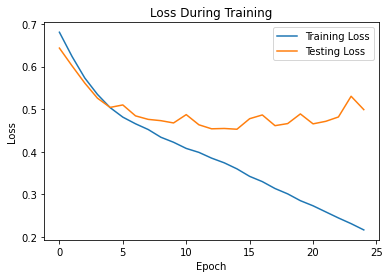

In [10]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

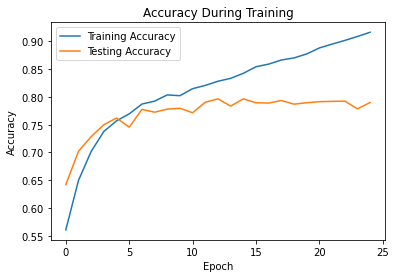

In [11]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [12]:
# === Save for Future Evaluation === #
hypermodel.save( 'SmallGrayReg_Results/TUNED_custom_catvdog_hypermodel.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [13]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 11.5s
Hyperparameter Tuning: 47.1978s
Training: 47.6991s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [14]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'SmallGrayReg_Results/TUNED_custom_catvdog_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,11.499994
1,Hyperparameter Tuning,47.197795
2,Training,47.699053


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [15]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'SmallGrayReg_Results/TUNED_custom_catvdog_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.560500,0.6420,0.680688,0.643429
1,2,0.649625,0.7020,0.623588,0.601611
2,3,0.701750,0.7285,0.573227,0.561283
3,4,0.737750,0.7500,0.534668,0.525794
4,5,0.756875,0.7620,0.503600,0.504137
5,6,0.769500,0.7455,0.481275,0.509912
6,7,0.787125,0.7775,0.465653,0.484274
7,8,0.792375,0.7725,0.452216,0.476024
8,9,0.803625,0.7780,0.434045,0.472984
9,10,0.802250,0.7795,0.422247,0.467624
